## Classification des éboulements 
Valentin Dall'Alba 2025
### Objectif général

Créer une carte de “temps de parcours” (travel time) à partir :  
- d’un modèle numérique de terrain (DEM) ;
- d’un ensemble de sources situées en altitude (points) ;
- d’un périmètre d’étude (polygone) ;
- et de points d’impact dispersés dans la vallée.

Le but final est de :  
- calculer combien de temps mettrait une "particule" pour descendre depuis les sources jusqu’à chaque pixel ;
- classer les impacts selon leur accessibilité temporelle depuis la zone source (par tranches de 5 %) ;
- délimiter les zones d'impact les plus proches des sources.

Fonctionne avec une ou plusieurs sources.

| Type de fichier      | Contenu                                                    | Exemple de nom    | Format attendu                       |
| -------------------- | ---------------------------------------------------------- | ----------------- | ------------------------------------ |
| 🌄 **DEM**           | Modèle d’élévation du terrain                              | `dem.tif`         | Raster GeoTIFF (mètres, CRS projeté) |
| 📍 **Sources**       | Points de départ du calcul | `sources.shp`     | Shapefile point                      |
| 🗺️ **Zone d’étude** | Polygone servant à découper le DEM                         | `zone.shp`        | Shapefile polygon                    |
| 🏠 **Impacts**   | Points d’impact de la zone source pour évaluer le travel time            | `impacts.shp` | Shapefile point                      |


In [ ]:
import os 
import numpy as np
from rasterio.mask import mask
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
from functions_FFM_DN import *

### Etape 1 — Charger et découper le DEM
- On lit le fichier dem.tif, le fichier sources et les autres fichiers d'entrées
- On découpe le raster selon la zone d’étude (zone.shp) pour ne garder que la zone utile.
- On récupère les infos de géoréférencement (résolution, transformée affine, CRS).

DEM shape: (443, 435)
Sources: 4 Impacts: 61000


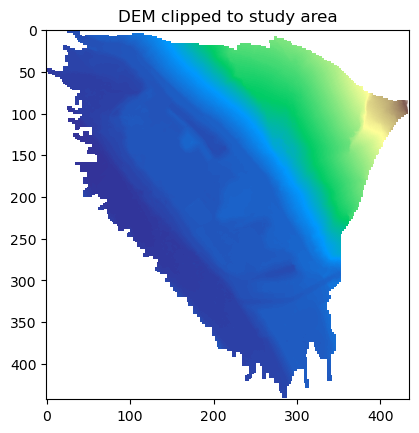

In [58]:
# PATH
dem_path     = 'data_raster/raster_dmt_1m.tif' # GeoTIFF DEM
zone_path    = 'data_shp/poly_zone_depot_EBO_10m3.shp' # polygone zone d'étude
sources_path = 'data_shp/sources_tests_multi.shp' # shapefile points sources
impact_path  = 'data_shp/zone_depot_EBO_10m3.shp' # shapefile points habitations
output_path  = 'output_test/multi_source/'

velocity_output_name          = 'velocity_field_1m.tif'
travel_time_ouput_name        = 'travel_time_source_multi.tif'
point_output_name             = 'impacts_classified_multi.shp'
isochrone_shp_output_name     = 'isochrones_multi.shp'
isochrone_raster_output_name  = 'isochrones_multi.tif'
count_impacts_shp_output_name = 'impacts_count_2m.shp'


# load inputs
data         = load_inputs(dem_path, zone_path, sources_path, impact_path)
dem          = data['dem']
transform    = data['transform']
profile      = data['profile']
gdf_sources  = data['gdf_sources']
gdf_impacts  = data['gdf_impacts']
gdf_poly     = data['gdf_poly']

# create mask: True where DEM has finite, non-zero elevation
mask_zone = np.isfinite(dem) & (dem == dem.min())
print('DEM shape:', dem.shape)
print('Sources:', len(gdf_sources), 'Impacts:', len(gdf_impacts))

# plot loaded DEM
dem[mask_zone] = np.nan
plt.imshow(dem, cmap='terrain')
plt.title('DEM clipped to study area'); 

### Étape 2 — Transformer l’altitude en vitesse ou importer directement une carte de vitesse existante
- Calculer la pente à partir du DEM
- Convertir la pente en vitesse :
    - vitesse m/s basée sur l'accélération gravitationnelle
- Option : Importer directement un raster de vitesse existant.

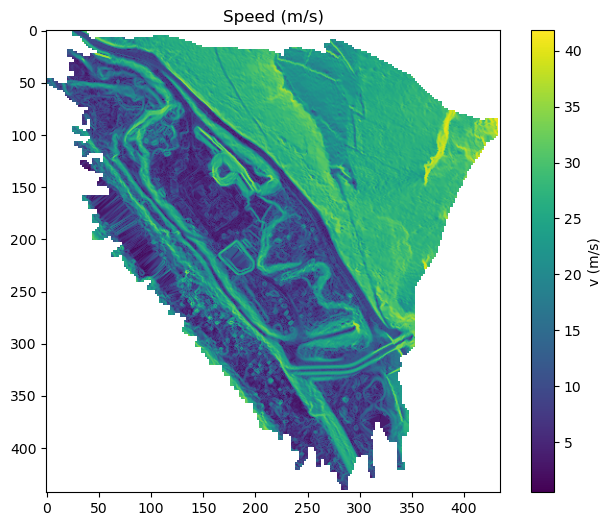

In [10]:
speed, profile_speed, slope = create_velocity_field(dem, profile, mask_zone, sigma=1.0, load_velocity_raster=None)
save_raster(speed, os.path.join(output_path, velocity_output_name), profile_speed, transform)

# speed plot
speed_plot = np.copy(speed)
speed_plot[np.isnan(mask_zone)] = np.nan
plot_speed_field(speed_plot, save_png=os.path.join(output_path, 'speed_field.png'))

### Étape 3 — Fast Marching : calcul du temps de parcours

- On place les sources (issues du shapefile sources.shp) comme points d’origine à temps 
  - T=0
- Puis on fait “grandir” le front de propagation dans toutes les directions selon la vitesse locale du terrain.
- L’algorithme Fast Marching (une version rapide du front de propagation) calcule le temps minimal pour atteindre chaque pixel depuis les sources.

Sortie : une matrice T → carte raster de travel time (en secondes).

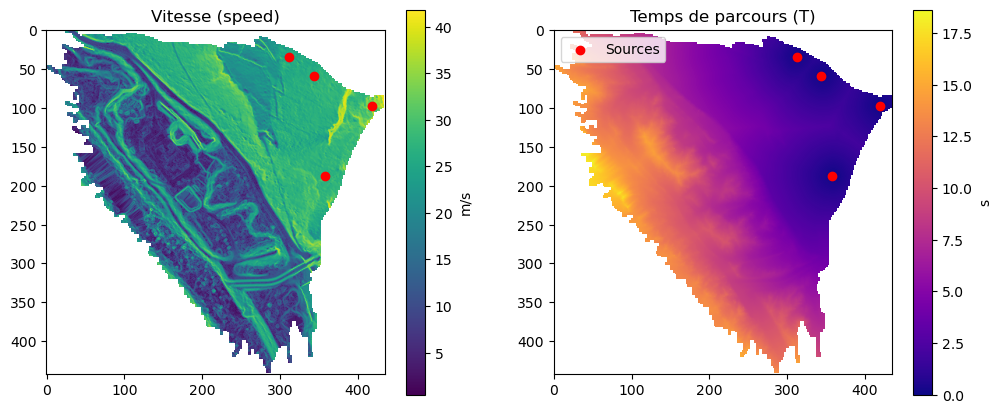

In [59]:
#calculate travel time
travel_time, sources_pix = step_apply_fast_marching(speed, gdf_sources, transform)
save_raster(travel_time, os.path.join(output_path, travel_time_ouput_name), profile_speed, transform)

#plot travel time and speed
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Vitesse (speed)")
plt.scatter([c for r,c in sources_pix], [r for r,c in sources_pix], color='red')
plt.imshow(speed, cmap="viridis")
plt.colorbar(label="m/s")

plt.subplot(1,2,2)
plt.title("Temps de parcours (T)")
plt.imshow(travel_time, cmap="plasma")
plt.colorbar(label="s")
plt.scatter([c for r,c in sources_pix], [r for r,c in sources_pix], color='red', label='Sources')
plt.legend()
plt.show()

### Étape 4 : Classifier l’impact et produire les sorties finales (shp et raster)
- Classifier l’impact par rang et par percentile
- Créer une isochrone classifiée (polygone et raster) à partir du temps de déplacement

c:\Users\Por63\Desktop\0003_SIG_local_data\02_test_DN\functions_FFM_DN.py:176: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_path)
c:\Users\Por63\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'travel_time' to 'travel_tim'
  ogr_write(


Gdf saved to output_test/multi_source/impacts_classified_multi.shp
Isochrone shapefile saved to: output_test/multi_source/isochrones_multi.shp


c:\Users\Por63\Desktop\0003_SIG_local_data\02_test_DN\functions_FFM_DN.py:167: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_path)
c:\Users\Por63\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'percent_min' to 'percent_mi'
  ogr_write(
c:\Users\Por63\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'percent_max' to 'percent_ma'
  ogr_write(


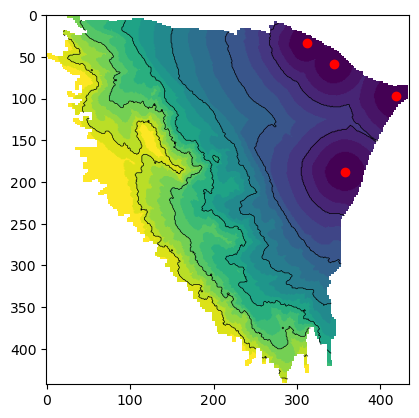

In [ ]:
# Classify impacts
results = extract_classify_impacts(travel_time, transform, gdf_impacts)

# Save results classify impacts
save_gdf_to_shp(results, os.path.join(output_path, point_output_name))

# Create isochrone map
iso, prof_iso, class_edges = transform_to_isochrone_map(travel_time, transform, profile)

#save shp and raster isochrone
iso_gdf = isochrone_to_shp(iso, transform, os.path.join(output_path, isochrone_shp_output_name), prof_iso)
save_raster(iso, os.path.join(output_path, isochrone_raster_output_name), prof_iso, transform)

#plot isochrone map
iso[mask_zone] = np.nan

plt.imshow(iso)
plt.scatter([c for r,c in sources_pix], [r for r,c in sources_pix], color='red')
plt.contour(iso, colors='black', linewidths=0.5)

### Etape 5 Compter les occurrences d’impact mises à l’échelle

- Compter le nombre d’impacts par cellule
- Calculer la probabilité d’impact
- Générer un fichier SHP

C:\Users\Por63\AppData\Local\Temp\ipykernel_17416\962663847.py:36: RuntimeWarning: Mean of empty slice
  dem = np.nanmean(dem_reshaped, axis=(1, 3))
C:\Users\Por63\AppData\Local\Temp\ipykernel_17416\962663847.py:116: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(output_path)
c:\Users\Por63\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(
C:\Users\Por63\AppData\Local\Temp\ipykernel_17416\962663847.py:116: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(output_path)
c:\Users\Por63\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(


Fini :
output_test/multi_source/impacts_count_2m.shp


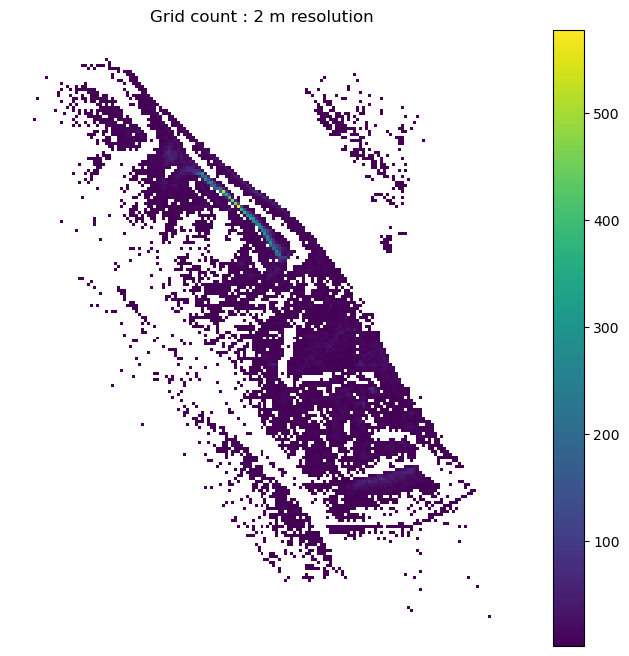

In [49]:
# Count impacts per grid cell at a define xy resolution
resolution = 2
grid_count = impacts_count(gdf_impacts, transform, profile, dem, resolution, output_path=output_path+count_impacts_shp_output_name)

#plot the count
gc_plot = gc.loc[gc['count']>1] 

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gc_plot.plot(column='count', ax=ax, cmap='viridis', legend=True, linewidth=0)
ax.set_title('Grid count : {} m resolution'.format(resolution))
ax.axis('off')
plt.show()